# TME4 - Perceptron
---

In [1]:
from arftools import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

## 1. Implémentation
----

In [2]:
def decorator_vec(fonc):
    def vecfonc(datax,datay,w,*args,**kwargs):
        if not hasattr(datay,"__len__"):
            datay = np.array([datay])
        datax,datay,w =  datax.reshape(len(datay),-1),datay.reshape(-1,1),w.reshape((1,-1))
        return fonc(datax,datay,w,*args,**kwargs)
    return vecfonc

@decorator_vec
def mse(datax,datay,w, b=0):
    """ retourne la moyenne de l'erreur aux moindres carres """
    return np.mean((np.dot(datax, w.T)+b - datay)**2)

@decorator_vec
def mse_g(datax,datay,w):
    """ retourne le gradient moyen de l'erreur au moindres carres """
    return np.mean(2 * datax * np.dot(datax, w.T) - datay)

@decorator_vec
def hinge(datax,datay,w, b=0):
    """ retourn la moyenne de l'erreur hinge """
    return np.mean(np.maximum(0, -datay * (np.dot(datax, w.T)+b)))

@decorator_vec
def hinge_g(datax,datay,w):
    """ retourne le gradient moyen de l'erreur hinge """
    # Utilisation d'un masque
    # On ne prend que les points mal classés
    mask = np.sign(np.maximum(0, -datay * np.dot(datax, w.T)))
    res = np.dot(mask.T, (-datay * datax))
    return res


In [10]:
import copy 

class Lineaire:
    def __init__(self,loss=hinge,loss_g=hinge_g,max_iter=1000,eps=0.01, init="random"):
        """ :loss: fonction de cout
            :loss_g: gradient de la fonction de cout
            :max_iter: nombre d'iterations
            :eps: pas de gradient
            :init: random ou mean (initialisation aléatoire ou avec la moyenne)
        """
        self.max_iter, self.eps = max_iter,eps
        self.loss, self.loss_g = loss, loss_g
        self.lossA , self.lossT = [], []
        self.init = init

    def fit(self,datax,datay,testx=False,testy=False):
        """ :datax: donnees de train
            :datay: label de train
            :testx: donnees de test
            :testy: label de test
        """
        datay = datay.reshape(-1,1)
        N = len(datay)
        datax = datax.reshape(N,-1)
        D = datax.shape[1]
        
        # Initialisation 
        if self.init == "random": 
            self.w = np.random.random((1,D))
        elif self.init == "mean":
            self.w = self.w = np.array([datax.mean(0)])
        self.winit = copy.deepcopy(self.w)
        
        for i in range(self.max_iter):
            self.lossA.append(self.loss(datax, datay, self.w))
            if type(testx) != bool:
                self.lossT.append(self.loss(testx, testy, self.w))
            self.w -= self.eps * self.loss_g(datax, datay, self.w)

    def predict(self,datax):
        if len(datax.shape)==1:
            datax = datax.reshape(1,-1)
        return np.sign(np.dot(datax, self.w.T)).reshape(-1)

    def score(self,datax,datay):
        return np.mean(self.predict(datax) == datay)


In [11]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")

def plot_error(datax,datay,f,step=10):
    grid,x1list,x2list=make_grid(xmin=-4,xmax=4,ymin=-4,ymax=4)
    plt.contourf(x1list,x2list,np.array([f(datax,datay,w) for w in grid]).reshape(x1list.shape),25)
    plt.colorbar()
    plt.show()


Tracer les isocourbes de l'erreur

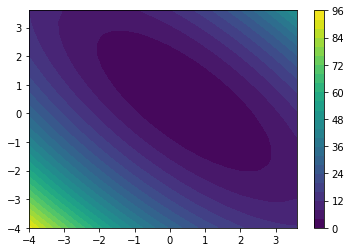

Score MSE : train 0.524000, test 0.520000


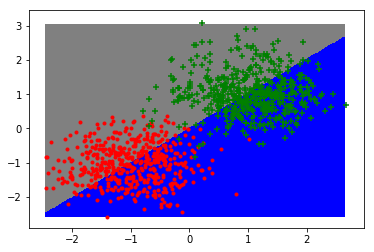

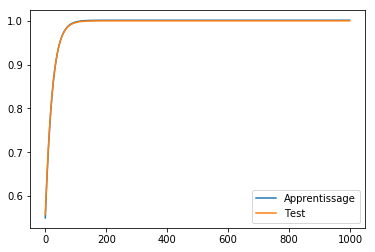

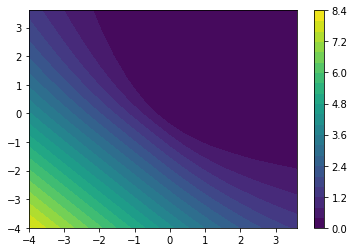

Score Hinge_loss : train 0.989000, test 0.992000


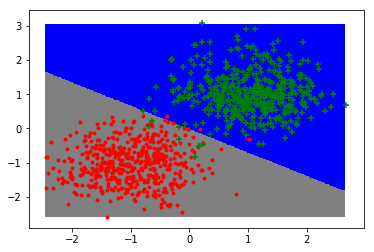

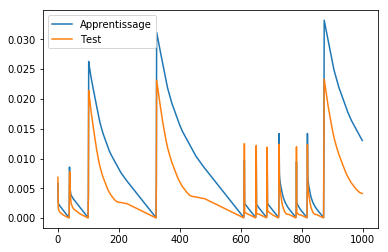

In [13]:
""" Tracer des isocourbes de l'erreur """
plt.ion()
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=0.5)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=0.5)

# MSE
plt.figure()
plot_error(trainx,trainy,mse)
perceptron1 = Lineaire(mse,mse_g,max_iter=1000,eps=0.01)
perceptron1.fit(trainx,trainy, testx, testy)
print("Score MSE : train %f, test %f"% (perceptron1.score(trainx,trainy),perceptron1.score(testx,testy)))
plt.figure()
plot_frontiere(trainx,perceptron1.predict,200)
plot_data(trainx,trainy)

plt.figure()
plt.plot(perceptron1.lossA, label = "Apprentissage")
plt.plot(perceptron1.lossT, label = "Test")
plt.legend()
plt.show()

# HINGE_LOSS
plt.figure()
plot_error(trainx,trainy,hinge)
perceptron2 = Lineaire(hinge,hinge_g,max_iter=1000,eps=0.01)
perceptron2.fit(trainx,trainy,testx, testy)
print("Score Hinge_loss : train %f, test %f"% (perceptron2.score(trainx,trainy),perceptron2.score(testx,testy)))
plt.figure()
plot_frontiere(trainx,perceptron2.predict,200)
plot_data(trainx,trainy)

plt.figure()
plt.plot(perceptron2.lossA, label = "Apprentissage")
plt.plot(perceptron2.lossT, label = "Test")
plt.legend()
plt.show()

On remarque que le coût aux moindres carrés n'est pas adapté à la classification. Car les points trop éloignés ont un impact sur la frontière de décision.

## 2. Données USPS
----

Chargement des données

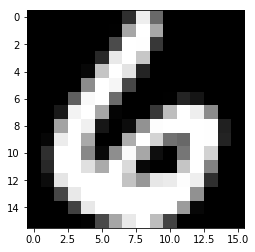

In [14]:
datax_train, datay_train = load_usps("data/usps_train.txt")
datax_test, datay_test = load_usps("data/usps_test.txt")

show_usps(datax_train[0])

### One versus One

In [15]:
def dataset1v1(datax, datay, c1, c2):
    # Extraction des données des 2 classes
    inds = np.where((datay == c1) | (datay == c2))[0]
    datax = datax[inds]

    # Labels +1 et -1
    datay = datay[inds]
    datay[datay == c1] = -1
    datay[datay == c2] = 1
    
    return datax, datay


Score : train 1.000000, test 0.997118


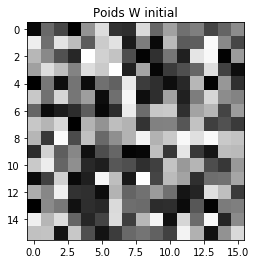

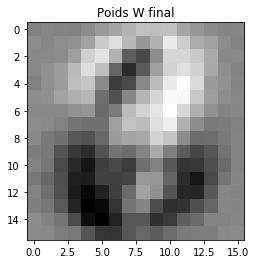

In [16]:
X_train, Y_train = dataset1v1(datax_train, datay_train, 6, 9)
X_test, Y_test = dataset1v1(datax_test, datay_test, 6, 9)

perceptron = Lineaire(hinge,hinge_g,max_iter=1000,eps=0.01)
perceptron.fit(X_train, Y_train)
print("Score : train %f, test %f"% (perceptron.score(X_train,Y_train),perceptron.score(X_test,Y_test)))
plt.title("Poids W initial")
plt.imshow(perceptron.winit.reshape(16,16), cmap="gray")
plt.show()
plt.title("Poids W final")
plt.imshow(perceptron.w.reshape(16,16), cmap="gray")
plt.show()

Score : train 1.000000, test 0.988372


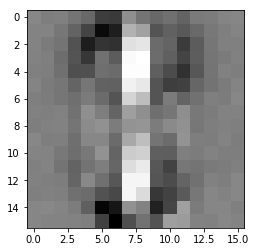

In [17]:
X_train, Y_train = dataset1v1(datax_train, datay_train, 1, 8)
X_test, Y_test = dataset1v1(datax_test, datay_test, 1, 8)

perceptron = Lineaire(hinge,hinge_g,max_iter=1000,eps=0.01)
perceptron.fit(X_train, Y_train)
print("Score : train %f, test %f"% (perceptron.score(X_train,Y_train),perceptron.score(X_test,Y_test)))
plt.imshow(perceptron.w.reshape(16,16), cmap="Greys")
plt.show()

Essayons avec une initialisation différente de w, qui peut s'avérer utile puisque l'initialisation a un impact sur la solution finale.

Score : train 1.000000, test 0.997118


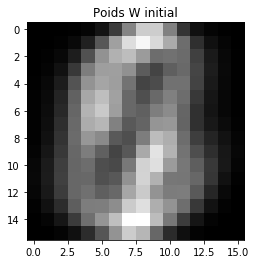

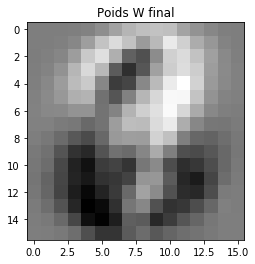

In [18]:
X_train, Y_train = dataset1v1(datax_train, datay_train, 6, 9)
X_test, Y_test = dataset1v1(datax_test, datay_test, 6, 9)

perceptron = Lineaire(hinge,hinge_g,max_iter=1000,eps=0.01, init="mean")
perceptron.fit(X_train, Y_train)
print("Score : train %f, test %f"% (perceptron.score(X_train,Y_train),perceptron.score(X_test,Y_test)))
plt.title("Poids W initial")
plt.imshow(perceptron.winit.reshape(16,16), cmap="gray")
plt.show()
plt.title("Poids W final")
plt.imshow(perceptron.w.reshape(16,16), cmap="gray")
plt.show()

### One versus All

In [19]:
def dataset1vall(datax, datay, c):
    # Extraction des données des 2 classes
    datax, datay = np.copy(datax), np.copy(datay)

    # Labels +1 et -1
    datay[datay != c] = -1
    datay[datay == c] = 1
    
    return datax, datay


Score : train 0.964202, test 0.946188


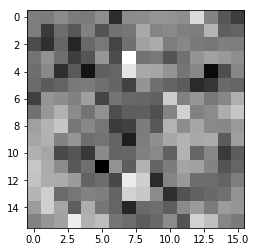

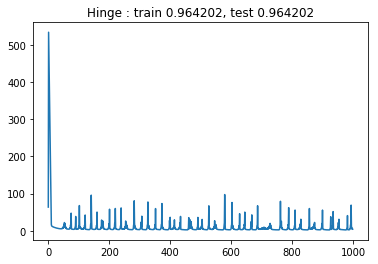

In [20]:
X_train, Y_train = dataset1vall(datax_train, datay_train, 8)
X_test, Y_test = dataset1vall(datax_test, datay_test, 8)

perceptron = Lineaire(hinge,hinge_g,max_iter=1000,eps=0.01)
perceptron.fit(X_train, Y_train)
print("Score : train %f, test %f"% (perceptron.score(X_train,Y_train),perceptron.score(X_test,Y_test)))
plt.imshow(perceptron.w.reshape(16,16), cmap="Greys")
plt.show()
text = "Hinge : train %f, test %f"% (perceptron.score(X_train,Y_train)\
                                     ,perceptron.score(X_train,Y_train))
plt.title(text)
plt.plot(perceptron.lossA)
plt.plot(perceptron.lossT)
plt.show()


Score : train 0.993279, test 0.979073


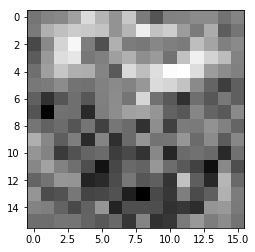

In [21]:
X_train, Y_train = dataset1vall(datax_train, datay_train, 6)
X_test, Y_test = dataset1vall(datax_test, datay_test, 6)

perceptron = Lineaire(hinge,hinge_g,max_iter=1000,eps=0.01)
perceptron.fit(X_train, Y_train)
print("Score : train %f, test %f"% (perceptron.score(X_train,Y_train),perceptron.score(X_test,Y_test)))
plt.imshow(perceptron.w.reshape(16,16), cmap="Greys")
plt.show()

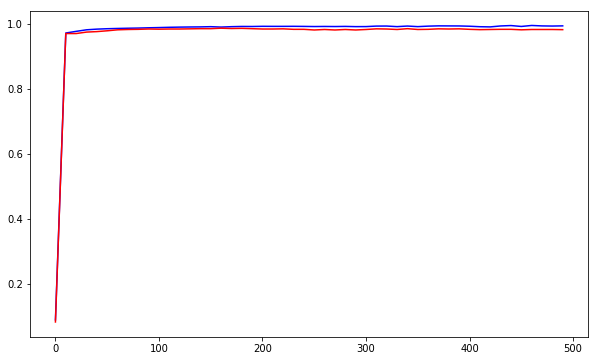

In [23]:
v_train, v_test = [], []
perceptron = Lineaire(hinge, hinge_g, max_iter=1000, eps=0.01)

for i in range(0, 500, 10):
    perceptron.max_iter = i
    perceptron.fit(X_train, Y_train)
    v_train.append(perceptron.score(X_train, Y_train))
    v_test.append(perceptron.score(X_test, Y_test))
plt.figure(figsize=(10,6))
plt.plot(range(0,500,10), v_train, 'b')
plt.plot(range(0,500,10), v_test, 'r')
plt.legend()
plt.show()

On n'observe pas de surapprentissage puisque les performances en apprentissage et en test sont très similaires.

## 3. Données 2D et projection
----

In [24]:
def affichage(modele=Lineaire, d_type=0, loss=hinge, loss_g=hinge_g, eps=1):
    plt.ion()
    trainx,trainy =  gen_arti(nbex=1000,data_type=d_type,epsilon=eps)
    testx,testy =  gen_arti(nbex=1000,data_type=d_type,epsilon=eps)

    plt.figure()
    plot_error(trainx,trainy,loss)
    perceptron = modele(loss,loss_g,max_iter=1000,eps=0.01)
    perceptron.fit(trainx,trainy)
    print("Score : train %f, test %f"% (perceptron.score(trainx,trainy),perceptron.score(testx,testy)))
    plt.figure()
    plot_frontiere(trainx,perceptron.predict,200)
    plot_data(trainx,trainy)

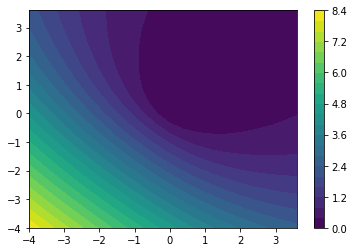

Score : train 0.911000, test 0.920000


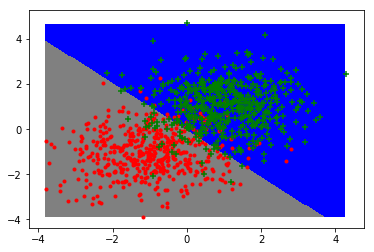

In [25]:
affichage()

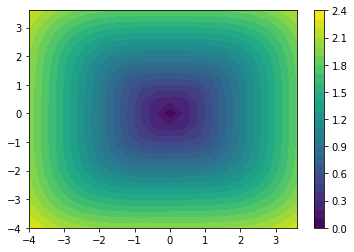

Score : train 0.497000, test 0.491000


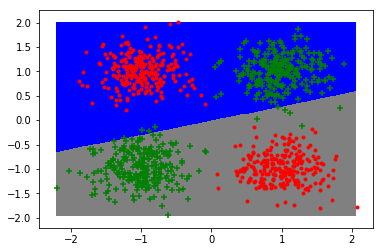

In [26]:
affichage(d_type=1, eps=0.1)

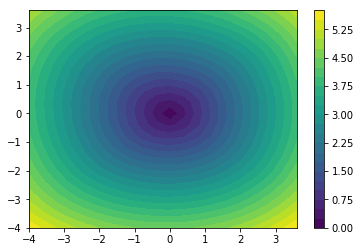

Score : train 0.503000, test 0.515000


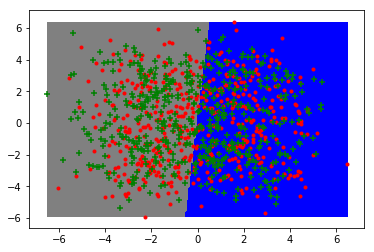

In [27]:
affichage(d_type=2, eps=1)

Les données ne sont plus linéairement séparables comme on peut le voir. C'est pourquoi notre algorithme n'est plus autant efficace.

In [47]:
def projection_polynomiale(datax, dim):
    p = np.vstack((np.ones(len(datax)), \
                           datax[:,0], \
                           datax[:,1],\
                           datax[:,0]**2, \
                           datax[:,1]**2, \
                           datax[:,0]*datax[:,1])).T
    return p[:,:dim]


In [48]:
projection_polynomiale(datax_train, 3)

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [44]:
class KernelTrick(Lineaire):
    """ Perceptron avec projection """
    
    def __init__(self, projection, dim=6, loss=hinge,loss_g=hinge_g,max_iter=1000,eps=0.01):
        """ :loss: fonction de cout
            :loss_g: gradient de la fonction de cout
            :max_iter: nombre d'iterations
            :eps: pas de gradient
            :project: projection
        """
        self.max_iter, self.eps = max_iter,eps
        self.loss, self.loss_g = loss, loss_g
        self.project, self.dim = projection, dim
        
    def fit(self,datax,datay,testx=None,testy=None):
        """ :datax: donnees de train
            :datay: label de train
            :testx: donnees de test
            :testy: label de test
        """
        datay = datay.reshape(-1,1)
        N = len(datay)
        datax = self.project(datax, self.dim)
        datax = datax.reshape(N,-1)
        D = datax.shape[1]
        self.w = np.random.random((1,D))
        
        for i in range(self.max_iter):
            #print(self.loss(datax, datay, self.w))
            self.w -= self.eps * self.loss_g(datax, datay, self.w)
            
    def predict(self,datax):
        datax = self.project(datax, self.dim)
        if len(datax.shape)==1:
            datax = datax.reshape(1,-1)
        return np.sign(np.dot(datax, self.w.T)).reshape(-1)
    

In [49]:
def affichage_project(projection, dim=6, d_type=0, loss=hinge, loss_g=hinge_g, eps=1):
    plt.ion()
    trainx,trainy =  gen_arti(nbex=1000,data_type=d_type,epsilon=eps)
    testx,testy =  gen_arti(nbex=1000,data_type=d_type,epsilon=eps)

    plt.figure()
    plot_error(trainx,trainy,loss)
    perceptron = KernelTrick(projection, dim, loss,loss_g,max_iter=1000,eps=0.01)
    perceptron.fit(trainx,trainy)
    print("Score : train %f, test %f"% (perceptron.score(trainx,trainy),perceptron.score(testx,testy)))
    plt.figure()
    plot_frontiere(trainx,perceptron.predict,200)
    plot_data(trainx,trainy)

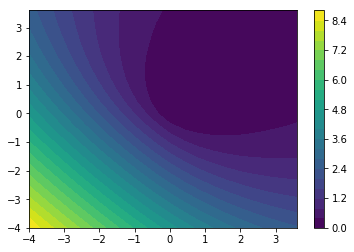

Score : train 0.904000, test 0.895000


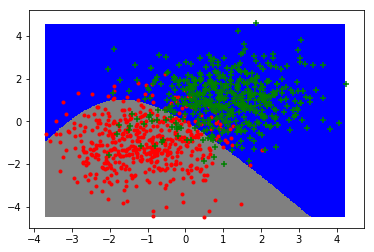

In [50]:
affichage_project(projection_polynomiale)

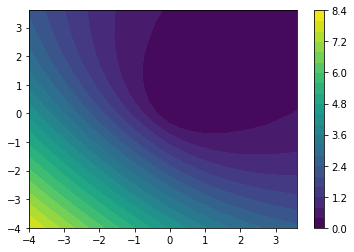

Score : train 0.898000, test 0.915000


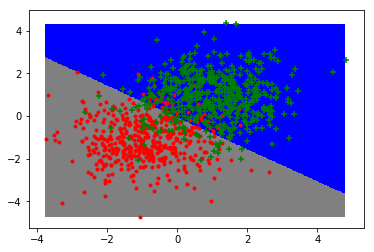

In [52]:
affichage_project(projection_polynomiale, 3)

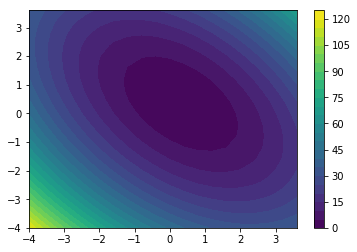

Score : train 0.434000, test 0.471000


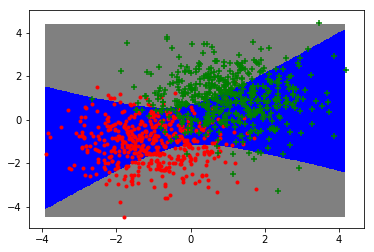

In [53]:
affichage_project(projection_polynomiale, loss=mse, loss_g=mse_g)

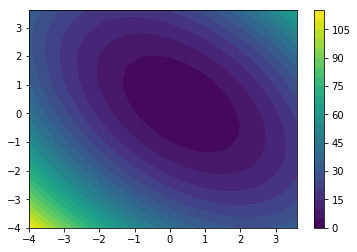

Score : train 0.472000, test 0.467000


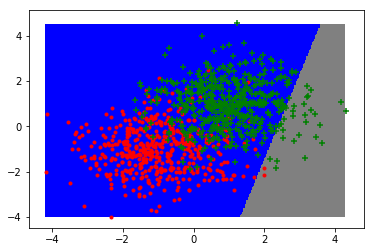

In [54]:
affichage_project(projection_polynomiale, 3, loss=mse, loss_g=mse_g)

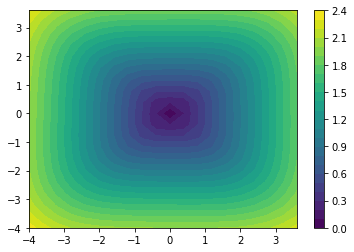

Score : train 0.993000, test 0.991000


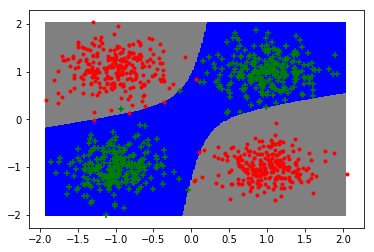

In [51]:
affichage_project(projection_polynomiale, d_type=1, eps=0.1)

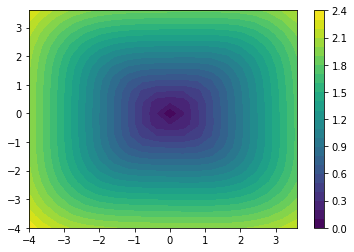

Score : train 0.442000, test 0.424000


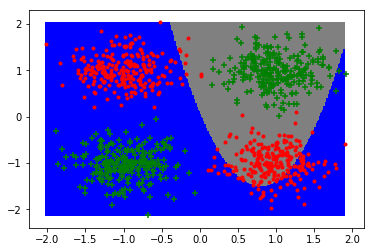

In [56]:
affichage_project(projection_polynomiale, 4, d_type=1, eps=0.1)

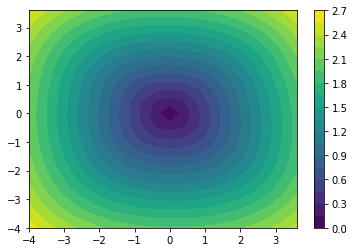

Score : train 0.905000, test 0.898000


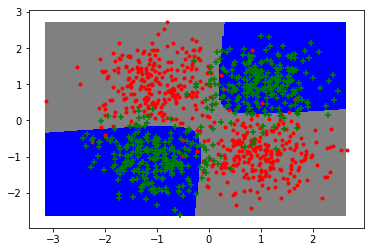

In [57]:
affichage_project(projection_polynomiale, d_type=1, eps=0.5)

On voit que la projection polynomiale est assez efficace dans le cas de 4 gaussiennes.

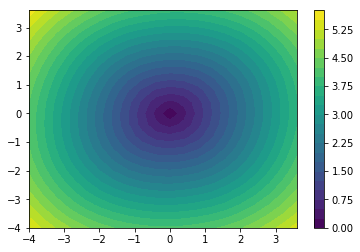

Score : train 0.505000, test 0.484000


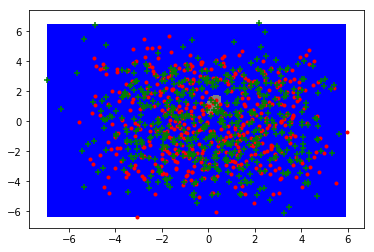

In [58]:
affichage_project(projection_polynomiale, d_type=2)

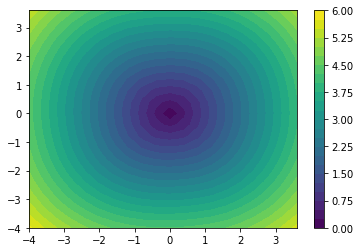

Score : train 0.488000, test 0.501000


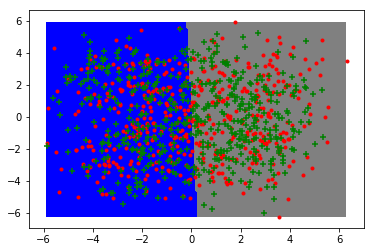

In [59]:
affichage_project(projection_polynomiale, 3, d_type=2)

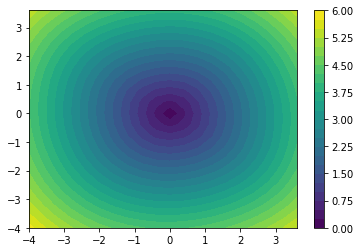

Score : train 0.493000, test 0.526000


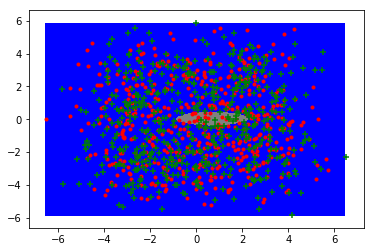

In [61]:
affichage_project(projection_polynomiale, 5, d_type=2)

Néanmoins, avec des données beaucoup plus confuses tel que l'échiquier, la projection polynomiale n'est plus vraiment efficace.

Avec un batch et ce type de donnée on arrive a convergence tres rapidement, on ne peut pas parler de sur-apprentissage vu les resltats du teste.
au bout d'un nombre tres grand d'itération le modele sur apprend sa base de teste et converge vers 1 alors que qu'il ne fait pas mieux de 0.98 sur les données du tests.
avec une difference de 0.02 on ne peut pas parler de sur apprentissage.

In [62]:
import copy

class Stochastique(object):
    def __init__(self,loss=hinge,loss_g=hinge_g,max_iter=1000,eps=0.01,\
                 random = True, projection = False):
        """ :loss: fonction de cout
            :loss_g: gradient de la fonction de cout
            :max_iter: nombre d'iterations
            :eps: pas de gradient
        """
        self.max_iter, self.eps = max_iter,eps
        self.loss, self.loss_g = loss, loss_g
        self.lossA , self.lossT = [], []
        self.random = random
        self.projection = projection 
        
    def fit(self,datax,datay,testx=None,testy=None):
        """ :datax: donnees de train
            :datay: label de train
            :testx: donnees de test
            :testy: label de test
        """
        self.lossA , self.lossT = [], []
        datax = self.projection(datax) if self.projection != False else datax 
        testx = self.projection(testx) if self.projection != False else testx
        
        datay = datay.reshape(-1,1) # une colonne et INF lignes 
        N = len(datay)
        datax = datax.reshape(N,-1)
        D = datax.shape[1]
        self.w = np.random.random((1,D)) if self.random == True else np.array([datax.mean(0)])         
        self.init_w = copy.deepcopy(self.w)
        
        for _ in range (self.max_iter):
            i = random.choice(range(0,len(datax)))
            datax_sample, datay_sample = datax[i], datay[i]
            datax_sample = np.array([datax_sample])
            datay_sample = np.array([datay_sample])
            ii = random.choice(range(0, len(testx)))
            testx_sample = np.array([testx[ii]])
            testy_sample = np.array([testy[ii]])
            self.lossA.append(self.loss(datax_sample , datay_sample , self.w))
            self.w = self.w - self.eps * self.loss_g(datax, datay, self.w)
            self.lossT.append(self.loss(testx_sample , testy_sample , self.w))
            

    def predict(self,datax):
        datax = self.projection(datax) if self.projection != False else datax 
        if len(datax.shape)==1:
            datax = datax.reshape(1,-1) # reshape obligatoire 
        return np.sign(np.dot(datax, self.w.T))
    
    def score(self,datax,datay):
        
        p =  self.predict(datax).reshape(len(datay))
        score = len(np.where(p == datay)[0])/len(datay)
        return score


La version batch converge plus rapidement mais présente un coût élevé tandis que la version stochastique est nettement moins coûteuse car elle ne prend en compte qu’un seul exemple à chaque itération, ce qui réduit le temps de calcul. Néanmoins, elle est moins précise car étant donné le tirage aléatoire des exemples, ces derniers ne le dirige pas forcément vers la même direction on peut observer ce phénomène à travers les oscillations, contrairement à la version batch qui est lisse avec quelques itérations.

1523623223.0795355 seconds wall time
Hinge : train 0.999235, test 0.997118


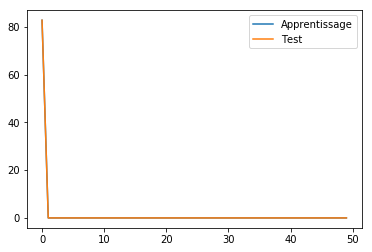

0.203690767288208 seconds wall time
Hinge : train 0.999235, test 0.997118


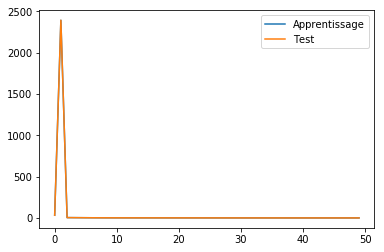

In [76]:
import time
import random

max_iter = 100
class1, class2= 6, 9
datax_train, datay_train = load_usps("data/USPS_train.txt")
datax_test, datay_test = load_usps("data/USPS_test.txt")
lx,ly= dataset1v1(datax_train,datay_train,class1,class2)
lxt,lyt= dataset1v1(datax_test,datay_test,class1,class2)
t0 = time.clock()
perceptron = Stochastique(hinge,hinge_g,max_iter=50,eps=0.1, \
                      random = True , projection = False)
print( (time.time() - t0), "seconds wall time")

perceptron.fit(lx,ly,lxt,lyt)
text = "Hinge : train %f, test %f"% (perceptron.score(lx,ly),perceptron.score(lxt,lyt))
print(text) 
plt.show()

plt.plot(perceptron.lossA, label = "Apprentissage")
plt.plot(perceptron.lossA, label = "Test")
plt.legend()
plt.show()

t0 = time.time()

perceptron = Lineaire(hinge,hinge_g,max_iter=50,eps=0.1)

perceptron.fit(lx,ly,lxt,lyt)
print( (time.time() - t0), "seconds wall time")

text = "Hinge : train %f, test %f"% (perceptron.score(lx,ly),perceptron.score(lxt,lyt))
print(text)
plt.show()

plt.plot(perceptron.lossA, label = "Apprentissage")
plt.plot(perceptron.lossA, label = "Test")
plt.legend()
plt.show()


Et enfin nous utlisons une approche bagging, composée de N perceptron, la decision sera une moyenne des scores obtenues par ces derniers.

In [77]:
class BaggedPerceptron:
    def __init__(self, nb_perceptron=10, **perceptron_parameters):
        self.clfs = [Stochastique(**perceptron_parameters) for _ in range(nb_perceptron)]
    
    def fit(self, *data):
        for clf in self.clfs:
            clf.fit(*data)
    
    def predict(self, testx):
        preds = np.array([clf.predict(testx) for clf in self.clfs])
        return np.array(preds.mean(0) > 0, dtype=int).T * 2 - 1

In [80]:
clf = BaggedPerceptron(20, max_iter=100, eps=0.01)
clf.fit(lx, ly, lxt, lyt)

In [ ]:
(clf.predict(lxt)[0] == lyt).mean()

Nous avons testé la méthode du Bagging avec 20 perceptrons afin d’avoir des résultats plus fiables. Nous obtenons alors un score moyen de 0.998 avec un temps de calcul raisonnable. 